# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort, Rémi Flamary

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Formulate the Mean Absolute Error (MAE) regression model as a Quadratic Program
- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [16]:
# Change here using YOUR first and last names
fn1 = "charles"
ln1 = "rigaud"
fn2 = "erwan"
ln2 = "celanie"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_rigaud_charles_and_celanie_erwan.ipynb


Some imports (install cvxopt if not already done so `!pip install cvxopt`):

In [17]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
import cvxopt
import pandas as pd

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

Time for LinearRegression: 0.001s
Coef :  [38.64424619]  Intercept : 9.919390944445563


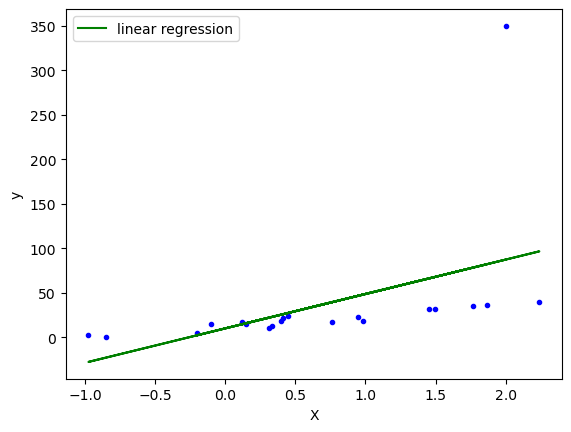

In [18]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                       noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
t0 = time.perf_counter()
reg = LinearRegression()
reg.fit(X, y)
print(f"Time for LinearRegression: {time.perf_counter() - t0:.3f}s")

# Visualize the model
x = X[:, 0]
y_pred = reg.coef_ * x + reg.intercept_
print("Coef : ",reg.coef_, " Intercept :", reg.intercept_)

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

<div class="alert alert-success">
    <b>QUESTION 0:</b>
     <ul>
       <li>Describe the issue you observe and suggest an explanation and a possible solution.</li>
    </ul>
</div>

The problem in this linear regression is that the oulier (upper right point) confuses the solver, indeed the LS method minimizes the sum of squared errors which overweights outliers.
A solution could be to use a ridge regression which includes a regularization term and fits well to linear problems problems.

## Part 1 : Mean Absolute Error regression

The Mean Absolute Error (MAE) regression model reads:

$$
\min_{w \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n \left|y_i - \langle w, x_i
\rangle-b \right| + \lambda \frac{1}{2}\|w\|_2^2
$$

where $\lambda > 0$ is the regularization parameter for quadratic
regularization.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Reformulate the optimization problem as a standard Quadratic Program of the form :</li></ul>
       
$$ \min_{z \in \mathbb{R}^p} f(w) = \frac{1}{2} z^T Q z + c^T z, \quad \text{ subject to } Gz\leq h \text{ and } Az=b $$
       
       
    
</div>

#Answer


---


## Reformulation of the MAE Regression Problem as a Quadratic Program (QP)

The given Mean Absolute Error (MAE) regression problem is:

$$
\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n \left|y_i - \langle w, x_i \rangle - b \right| + \lambda \frac{1}{2}\|w\|_2^2
$$



---


### Reformulation of $|y_i - \langle w, x_i \rangle - b|$

We introduce variables $\xi_i$ for each data point $i$ such that:

$$
\xi_i \geq y_i - \langle w, x_i \rangle - b \quad \text{and} \quad \xi_i \geq - (y_i - \langle w, x_i \rangle - b)
$$

This ensures $\xi_i \geq |y_i - \langle w, x_i \rangle - b|$, transforming the problem into a linear form.



---


### Reformulation as a QP Problem

1. **Variables:**

   We define the optimization variables as $z = [w^T, b, \xi^T]^T \in \mathbb{R}^{p+1+n}$, where $\xi = [\xi_1, \xi_2, \ldots, \xi_n]^T \in \mathbb{R}^n$.

2. **Objective Function:**

   The objective function can be written as:

   $$
   \min_{z} \quad \frac{1}{2} \lambda \|w\|_2^2 + \frac{1}{n} \sum_{i=1}^n \xi_i
   $$

   This can be rewritten in standard quadratic form:

   $$
   f(z) = \frac{1}{2} z^T Q z + c^T z
   $$

   Where:
   - $Q = \text{diag}(\lambda I_p, 0, 0_n) \in \mathbb{R}^{(p+1+n) \times (p+1+n)}$ (only the $w$-related terms have quadratic coefficients),
   - $c = [0_p^T, 0, \frac{1}{n} \mathbf{1}_n^T]^T \in \mathbb{R}^{p+1+n}$.

3. **Constraints:**

   The constraints are given by:

   $$
   y_i - \langle w, x_i \rangle - b \leq \xi_i \quad \forall i = 1, \ldots, n
   $$
   $$
   -(y_i - \langle w, x_i \rangle - b) \leq \xi_i \quad \forall i = 1, \ldots, n
   $$
   this implies : $$ 0 \leq \xi_i \quad \forall i = 1, \ldots, n$$

   These constraints can be written in matrix form as:

   $$
   Gz \leq h
   $$

   Where:
   - $G = \begin{bmatrix} -X & -\mathbf{1}_n & -I_n \\ X & \mathbf{1}_n & -I_n \end{bmatrix} \in \mathbb{R}^{2n \times (p+1+n)}$,
   - $h = [-y; y] \in \mathbb{R}^{2n}$, where $y = [y_1, y_2, \ldots, y_n]^T$.

4. **Equality Constraints:**

   There are no equality constraints in this formulation, so $A = 0$ and $b = 0$.



---


### Final QP Formulation

$$
\min_{z \in \mathbb{R}^{p+1+n}} \quad \frac{1}{2} z^T Q z + c^T z
$$
subject to:

$$
Gz \leq h
$$
with no equality constraints.


<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>Code the solver for the regularized MAE using the QP solver from `cvxopt` (see example <a href="https://cvxopt.org/examples/tutorial/qp.html">here</a>) or another open source QP solver of your choice. Note that for cvxopt`, numpy array have to be converted to cvxopt `matrix`.</li></ul>          
</div>

In [19]:
from cvxopt import matrix, solvers

def solve_reg_mae(X,y,reg=0):

    n_samples, n_features = X.shape
    print(X.shape)

    # TODO

    # Q
    Q = np.zeros((n_features + 1 + n_samples, n_features + 1 + n_samples))
    Q[0:n_features, 0:n_features ] = reg * np.eye(n_features)  # Regularization term for w

    # c
    c = np.zeros(n_features + 1 + n_samples)
    c[n_features + 1:] = 1 / n_samples

    # G
    G_top = np.hstack([-X, -np.ones((n_samples, 1)), -np.eye(n_samples)])
    G_bottom = np.hstack([X, np.ones((n_samples, 1)), -np.eye(n_samples)])
    G = np.vstack([G_top, G_bottom])


    # h
    h = np.hstack([-y, y])

    print("Q shape :", Q.shape)
    print("c shape :", c.shape)
    print("G shape :", G.shape)
    print("h shape :", h.shape)

    sol = solvers.qp(matrix(Q), matrix(c), matrix(G), matrix(h))
    w = np.array(sol['x'])[1:n_features+1,0] # recover w
    b = np.array(sol['x'])[0] # recover b (first component of z)
    return w, b

Apply the solver on the toy data and compare it to the previous LinearRegression solution with $\lambda=0.1$.

Discuss the robustness of MAE VS LS.

Discuss the computational time of MAE QP solver. What is the number of variable to optimize?

How well will it scale  to large datasets?     



(20, 1)
Q shape : (22, 22)
c shape : (22,)
G shape : (40, 22)
h shape : (40,)
     pcost       dcost       gap    pres   dres
 0:  7.4172e+01  1.6546e+05  3e+06  3e+00  2e+03
 1:  3.3414e+02 -2.7919e+04  3e+04  3e-02  3e+01
 2:  2.8389e+02 -1.1098e+03  1e+03  1e-03  1e+00
 3:  1.8948e+02  1.9697e+01  2e+02  5e-16  1e-14
 4:  2.7104e+01  2.0367e+01  7e+00  5e-16  6e-16
 5:  2.3938e+01  2.2510e+01  1e+00  3e-16  4e-16
 6:  2.3181e+01  2.3041e+01  1e-01  3e-16  3e-16
 7:  2.3121e+01  2.3110e+01  1e-02  7e-16  6e-16
 8:  2.3115e+01  2.3115e+01  1e-04  4e-16  7e-16
 9:  2.3115e+01  2.3115e+01  1e-06  2e-16  9e-16
Optimal solution found.
Time for MAE QP solver: 0.007s


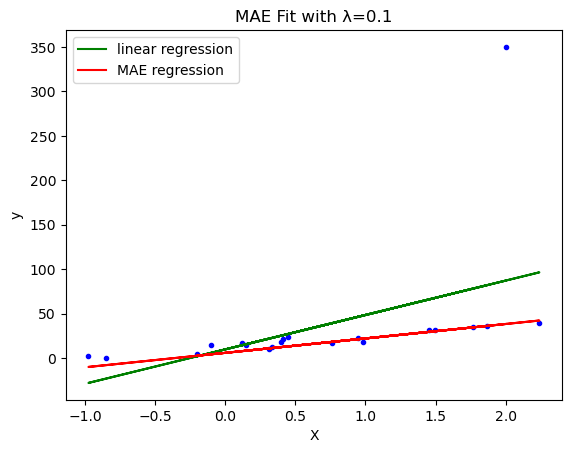

Estimated w: [16.21908708]
Estimated b: [5.97805572]


In [20]:
t0 = time.perf_counter()
w_mae, b_mae = solve_reg_mae(X,y,reg=0.1)
print(f"Time for MAE QP solver: {time.perf_counter() - t0:.3f}s")


ypred_mae = X.dot(w_mae)+b_mae

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.plot(x, ypred_mae, 'r-', label="MAE regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.title(f"MAE Fit with λ={0.1}")
plt.show()

print(f"Estimated w: {w_mae}")
print(f"Estimated b: {b_mae}")

LS is sensitive to outliers due to its squared error which overweights outliers while MAE is using an absolute error that doesn't overweight large errors.

In this case MAE is much more robust, as we can see on the graph.

Computationaly-wise, there are $n_{variables}=n_{features}+1+n_{samples}$ to optimize ($1$ corresponding to the bias $b$) and the computational time is of $O(n_{variables}^3)$ which means that the computational time increase in cubic function of the number of samples.
Making MAE highly unadapted to large datasets and variable datasets (because it doesn't take outliers into accoun).

## Part 2: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [21]:
epsilon = 1.

def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$

INSERT YOUR ANSWER HERE

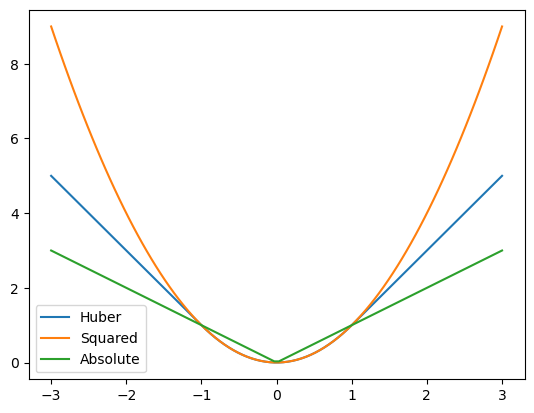

In [22]:
### TODO
plot_x = np.linspace(-3, 3, 100)
plt.plot(plot_x, huber(plot_x, epsilon=epsilon), label='Huber')
plt.plot(plot_x, plot_x ** 2, label='Squared')
plt.plot(plot_x, np.abs(plot_x), label='Absolute')
plt.legend()

### END TODO

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Justify the convexity of the Huber function as defined above.</li>
       <li>Justify the smoothness of the Huber function as defined above and propose a value of for the Lipschitz constant of its gradient.</li>
    </ul>
</div>

# Answer
  ## 1. Convexity of $H_{\varepsilon}$

  Let's analyse $H_{\varepsilon}$ second derivative to check it's convexity.

  ### 1.1. Second derivative in the interior of regions

  - **Case 1**: $\lvert x\rvert < \varepsilon$.  
    Here, $H_{\varepsilon}(x) = x^2$. Its second derivative is
    $$
      \frac{d^2}{dx^2} \bigl(x^2\bigr) = 2 > 0.
    $$

  - **Case 2**: $\lvert x\rvert > \varepsilon$.  
    Here, $H_{\varepsilon}(x) = 2\\varepsilon\|x| - \varepsilon^2$.  
    The function $|x|$ is convex; multiplying by a positive constant ($2\varepsilon$) and subtracting the constant $\varepsilon^2$ both preserve convexity. In particular, for $x > \varepsilon$,
    $$
    H_{\varepsilon}(x) = 2\varepsilon\ x - \varepsilon^2, \quad
    \frac{d^2}{dx^2}\bigl(2\varepsilon\ x - \varepsilon^2\bigr) = 0.
    $$

    And for $x < -\varepsilon$, $$H_{\varepsilon}(x) = -2\varepsilon\ x - \varepsilon^2,  \quad
    \frac{d^2}{dx^2}\bigl(-2\varepsilon\ x - \varepsilon^2\bigr) = 0.$$

  Hence in each region (inside and outside $\pm \varepsilon$), the second derivative is either 2 or 0, which is nonnegative.

  ### 1.2. Checking continuity and matching at $x = \pm \varepsilon$

  - At $x = \varepsilon$:

    $$
      \lim_{x \to \varepsilon^-} H_{\varepsilon}(x)
      = \varepsilon^2,
      \quad
      \lim_{x \to \varepsilon^+} H_{\varepsilon}(x)
      = 2\varepsilon^2 - \varepsilon^2
      = \varepsilon^2.
    $$

    So $H_{\varepsilon}$ is continuous at $x = \varepsilon$. By a similar argument, it is continuous at $x = -\varepsilon$.  

  Since each piece ($x^2$ and $2\,\varepsilon\,|x| - \varepsilon^2$) is convex on its own domain, and they meet continuously in a convex fashion at the boundaries, the overall function is convex.  

  **Therefore, $H_{\varepsilon}$ is convex.**

  ---

  ## 2. Smoothness of $H_{\varepsilon}$ and Lipschitz constant of the gradient

  ### 2.1. First derivative of $H_{\varepsilon}$

  We compute $H_{\varepsilon}'(x)$ in each region:

  - **Case 1**: $|x| < \varepsilon$.  
    $$
      H_{\varepsilon}(x) \=\ x^2
      \quad\Longrightarrow\quad
      H_{\varepsilon}'(x) \=\ 2x.
    $$

  - **Case 2**: $x > \varepsilon$.  
    $$
      H_{\varepsilon}(x) \=\ 2\\varepsilon x - \varepsilon^2
      \quad\Longrightarrow\quad
      H_{\varepsilon}'(x) = 2\varepsilon.
    $$

  - **Case 3**: $x < -\varepsilon$.  
    $$
      H_{\varepsilon}(x) = -2\varepsilon x - \varepsilon^2
      \quad\Longrightarrow\quad
      H_{\varepsilon}'(x) = -2\varepsilon.
    $$

  At $x = \pm \varepsilon$, left- and right-derivatives match:

  $$
  \lim_{x \to \varepsilon^-} 2x = 2\varepsilon,
  \quad
  \lim_{x \to \varepsilon^+} 2\,\varepsilon = 2\varepsilon.
  $$

  Similarly at $x=-\varepsilon$. Hence $H_{\varepsilon}'(x)$ is continuous on $\mathbb{R}$.

  Therefore,
  $$
  H_{\varepsilon} \in C^1(\mathbb{R}).
  $$

  so $H_{\varepsilon}$ is smooth.

  ### 2.2. Lipschitz continuity (smoothness) of $H_{\varepsilon}'$

  To show $H_{\varepsilon}'$ is $L$-Lipschitz, we check its second derivative (where it exists) or use piecewise bounds:

  - In the region $|x| < \varepsilon$, $H_{\varepsilon}'(x) = 2x$, $H_{\varepsilon}''(x) = 2$
  - Outside this region, $H_{\varepsilon}'(x)$ is a constant ($\pm 2\varepsilon$), $H_{\varepsilon}''(x)=0$

  Which implies :

  $$
  |H_{\varepsilon}''(x)| \;\le\; 2 \quad \text{for all } x \text{ where it is defined}.
  $$

  Thus,

  $$
  |H_{\varepsilon}'(x) - H_{\varepsilon}'(y)|
  \;\le\; 2\,|x-y|
  \quad \forall x,y.
  $$

  So we can take

  $$
  L = 2
  $$

  as a valid Lipschitz constant for the gradient of $H_{\varepsilon}$ (i.e., $H_{\varepsilon}$ is 2-smooth).


<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

# Answer

We coded a "scalar version" of the huber to test it with the check_grad function since it doesn't takes a similar input as the given huber function.

check_grad takes only one point as it's entrance while huber takes a list of point to evaluate.

That appart, we obtain pretty good results, the error being between 0 and 10-8.

In [23]:
### TODO

from scipy.optimize import check_grad
import pandas as pd

def huber_derivative(x, epsilon = epsilon):
    deriv = np.zeros_like(x)
    # mask for the quadratic region
    mask = np.abs(x) < epsilon

    deriv[mask] = 2 * x[mask]
    deriv[(x >  epsilon)] =  2 * epsilon
    deriv[(x < -epsilon)] = -2 * epsilon
    return deriv

#with x = y-y'
def grad_huber(x ,epsilon=epsilon):
  return np.transpose([huber_derivative(x), -huber_derivative(x)])

#Checking gradient viability with scikit
#the check_grad function expect functions to take a point as entries, so we quickly adapt previous func to this

def huber_wrapped(x, epsilon=epsilon):
    x = x[0] - x[1]
    if np.abs(x) < epsilon:
        return x ** 2
    else:
        return 2 * epsilon * np.abs(x) - epsilon ** 2

def huber_derivative_wrapped(x, epsilon=epsilon):
        if np.abs(x) < epsilon:
            return 2 * x
        elif x >= epsilon:
            return 2 * epsilon
        else:  # x < -epsilon
            return -2 * epsilon

def grad_huber_wrapped(x, epsilon=epsilon):
    return [huber_derivative_wrapped(x[0] - x[1]), -huber_derivative_wrapped(x[0] - x[1])]

##Let's create a list of interesting points :

check_grad_df = pd.DataFrame(columns=['Point', 'error', "in_quadratic_space"])
check_grad_df['Point'] = [[k , 0] for k in np.linspace(-3,3,20)]
check_grad_df['error'] = [check_grad(huber_wrapped, grad_huber_wrapped, [k, 0]) for k in np.linspace(-3,3,20)]
check_grad_df['in_quadratic_space'] = [np.abs(k) < epsilon for k in np.linspace(-3,3,20)]

print(check_grad_df)

print("Mean error : ", np.mean(check_grad_df['error']))

#
### END TODO

                        Point         error  in_quadratic_space
0                   [-3.0, 0]  0.000000e+00               False
1    [-2.6842105263157894, 0]  0.000000e+00               False
2    [-2.3684210526315788, 0]  0.000000e+00               False
3    [-2.0526315789473686, 0]  0.000000e+00               False
4     [-1.736842105263158, 0]  0.000000e+00               False
5    [-1.4210526315789473, 0]  0.000000e+00               False
6     [-1.105263157894737, 0]  0.000000e+00               False
7    [-0.7894736842105265, 0]  2.153536e-08                True
8   [-0.47368421052631593, 0]  2.108072e-08                True
9    [-0.1578947368421053, 0]  2.107345e-08                True
10    [0.1578947368421053, 0]  2.107345e-08                True
11    [0.4736842105263155, 0]  2.108072e-08                True
12    [0.7894736842105261, 0]  1.582694e-08                True
13    [1.1052631578947363, 0]  0.000000e+00               False
14     [1.421052631578947, 0]  0.000000e



---



Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

QUESTION 7:

Let us consider for $ \mathcal{R} $ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$.

Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.

# Answer


---


## Case $\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$

In this case, we should use proximal methods because of the non-smoothness induced by the $\ell_1$ norm. The problem is separable, proximal methods are specially designed for this kind of problems. The low number of feature makes us choose proximal gradient descent over proximal coordinate descent.


---


## Case $\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$

In this case the problem is smooth unlocking a new range of method. Such as L-BFGS, GD and CD. The more efficient woud be L-BFGS who tends to converge quicker than the two other.

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    </li>
    <li>Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). Your are expected to make a plot of the regression fit.</li>
    </ul>
</div>

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

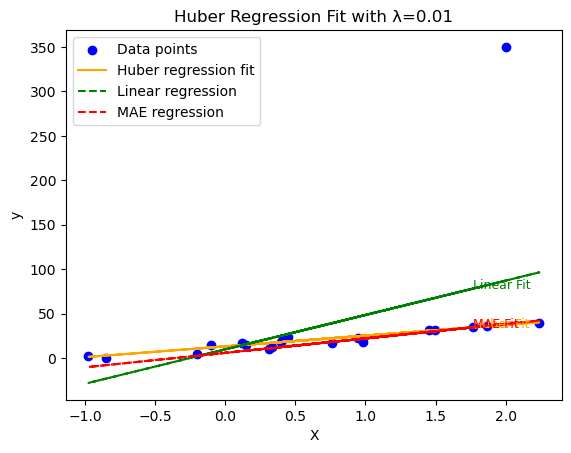

Estimated w: [12.090271]
Estimated b: 13.259192539850645


In [24]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(w ** 2)

def grad_pobj_l2(params, X, y, lbda=lbda, epsilon=epsilon):
    """Gradient of the primal objective with respect to w and b."""
    n, p = X.shape
    w = params[1:]
    b = params[0]

    residuals = y - np.dot(X, w) - b
    grad_loss = huber_derivative(residuals, epsilon=epsilon)

    grad_b = -np.mean(grad_loss)
    grad_w = -np.dot(grad_loss, X) / n + 2 * lbda * w

    grad = np.zeros_like(params)
    grad[0] = grad_b
    grad[1:] = grad_w
    return grad

def huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon):
    # TODO
    n, p = X.shape
    initial_params = np.zeros(p + 1)  # Initialize w and b as zeros
    params, _, _ = fmin_l_bfgs_b(
        pobj_l2, initial_params, fprime=grad_pobj_l2, args=(X, y, lbda, epsilon)
    )
    # END TODO
    return params

# TODO  (for visualization)
params = huber_lbfgs_l2(X, y, lbda=lbda, epsilon=epsilon)
b_hat = params[0]
w_hat = params[1:]

# Make predictions
y_pred_lbfgs = np.dot(X, w_hat) + b_hat

plt.scatter(x, y, label="Data points", color="blue")
plt.plot(x, y_pred_lbfgs, label="Huber regression fit", color="orange")
plt.plot(x, y_pred, 'g--', label="Linear regression")
plt.plot(x, ypred_mae, 'r--', label="MAE regression")

plt.text(x[-1], y_pred_lbfgs[-1], "Huber Fit", color="orange", fontsize=9, ha='left')
plt.text(x[-1], y_pred[-1], "Linear Fit", color="green", fontsize=9, ha='left')
plt.text(x[-1], ypred_mae[-1], "MAE Fit", color="red", fontsize=9, ha='left')

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title(f"Huber Regression Fit with λ={lbda}")
plt.show()

print(f"Estimated w: {w_hat}")
print(f"Estimated b: {b_hat}")

# END TODO

## Part 3: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [25]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [26]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers, args=()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(str(args) + ' Regularization')
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 9a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method.
    </li>
    </ul>
</div>

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

**Computation of the Lipschitz Constant of the Gradient**

We consider the problem
$$
(\mathcal{P}_{f,\mathcal{R}}):
\quad
\min_{w \in \mathbb{R}^p,\; b \in \mathbb{R}}
\;\;
\frac{1}{n}\sum_{i=1}^n f\bigl(y_i - x_i^\top w - b\bigr)
\;+\;\lambda \,\mathcal{R}(w),
$$
where
$$
f(x) \;=\; H_{\epsilon}(x)
\;=\;
\begin{cases}
x^2, & |x| < \epsilon,\\[6pt]
2\,\epsilon\,|x| \;-\;\epsilon^2, & |x|\ge \epsilon.
\end{cases}
$$

---

## 1. Definition of the data-fitting term

Define
$$
g(w,b)
\;=\;
\frac{1}{n}\,\sum_{i=1}^n f\bigl(r_i(w,b)\bigr)
\quad\text{where}\quad
r_i(w,b) \;=\; y_i - x_i^\top w - b.
$$

We want to find a constant \(L\) such that for all \((w,b)\) and \((w',b')\),
$$
\bigl\|\nabla g(w,b) - \nabla g(w',b')\bigr\|
\;\le\;
L\,\bigl\|(w,b) - (w',b')\bigr\|.
$$
Equivalently, \(L\) is an upper bound on the spectral norm of the Hessian of \(g\).

---

## 2. Gradient of the data-fitting term

Let us compute $\nabla g(w,b)$. Observe:
$$
r_i(w,b) \;=\; y_i \;-\; x_i^\top w \;-\; b.
$$

- **Gradient w.r.t. \(w\)**:
  $$
  \frac{\partial}{\partial w}\, f\bigl(r_i(w,b)\bigr)
  \;=\;
  f'\bigl(r_i(w,b)\bigr)\,\frac{\partial}{\partial w}\bigl(y_i - x_i^\top w - b\bigr)
  \;=\;
  -\,f'\bigl(r_i(w,b)\bigr)\,x_i.
  $$
- **Gradient w.r.t. \(b\)**:
  $$
  \frac{\partial}{\partial b}\, f\bigl(r_i(w,b)\bigr)
  \;=\;
  f'\bigl(r_i(w,b)\bigr)\,\frac{\partial}{\partial b}\bigl(y_i - x_i^\top w - b\bigr)
  \;=\;
  -\,f'\bigl(r_i(w,b)\bigr).
  $$

Hence,
$$
\nabla g(w,b)
\;=\;
\begin{pmatrix}
\nabla_w g(w,b) \\[4pt]
\partial_b g(w,b)
\end{pmatrix}
\;=\;
\frac{1}{n}\,\sum_{i=1}^n
\begin{pmatrix}
-\,f'\bigl(r_i(w,b)\bigr)\,x_i\\
-\,f'\bigl(r_i(w,b)\bigr)
\end{pmatrix}.
$$

---

## 3. Hessian of the data-fitting term

We now compute the Hessian $\nabla^2 g(w)$ and Hessian $\nabla^2 g(b)$. Note that
$$
\frac{\partial r_i}{\partial w} = -\,x_i,
\quad
\frac{\partial r_i}{\partial b} = -\,1.
$$
By the chain rule,
$$
\nabla_{w}^2 g(w)
\;=\;
\frac{1}{n}\,\sum_{i=1}^n
f''\bigl(r_i(w,b)\bigr)\;
x_i x_i^T
$$


With respect to b,
$$
\nabla_{b}^2 g(b)
\;=\;
\frac{1}{n}\sum_{i=1}^n
f''\bigl(r_i(w,b)\bigr)\,
$$

---

## 4. Lipschitz constant of $\nabla g$

With respect to w :

Since $f''(x)\le 2$ for all $x$ (because $f = H_{\varepsilon}$),

$$
\nabla_{w}^2 g(w,b)
\;\preceq\;
\frac{2}{n}\,\sum_{i=1}^n
x_i x_i^T
$$
in the sense of positive semidefinite ordering. Taking the spectral norm,
$$
\bigl\|\nabla_{w}^2 g(w,b)\bigr\|
\;\le\;
\frac{2}{n}\;\Bigl\|
\sum_{i=1}^n
x_i x_i^T
\Bigr\|.
$$

Hence a valid Lipschitz constant $L$ for $\nabla g$ is
$$
L_{w}
\;=\;
\frac{2}{n}
\;\lambda_{\max}\!\Bigl(
\sum_{i=1}^n
x_i x_i^T
\Bigr),
$$
where $\lambda_{\max}(\cdot)$ denotes the largest eigenvalue (for symmetric matrices, it equals the spectral norm).

Thus, **the Lipschitz constant** of the gradient of the data-fitting term w.r.t w is:
$$
\boxed{
L_w
\;=\;
\frac{2}{n}
\;\lambda_{\max}\!\Bigl(
\sum_{i=1}^n
x_i x_i^T
\Bigr).
}
$$

With respect to b now :

Since $f''(x)\le 2$ for all $x$ (because $f = H_{\varepsilon}$),

$$
\nabla_{b}^2 g(w,b)
\;\preceq\;
\frac{2}{n}\,\sum_{i=1}^n
1
$$
in the sense of positive semidefinite ordering. Taking the spectral norm,
$$
\bigl\|\nabla_{b}^2 g(w,b)\bigr\|
\;\le\;
\frac{2}{n}\;\Bigl\|
\sum_{i=1}^n
1
\Bigr\|.
$$


$$
\boxed{
L_b
\;=\;
2
}
$$
---


We optionnaly return a times list in our algorithms. This will be useful for the last question where we have to plot the

In [27]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=(), monitor_time=None):
    """Proximal gradient descent algorithm.

    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.

    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """

    x = x_init.copy()
    x_list = []
    t_list= []
    t_start = time.time()
    for i in range(n_iter):
        ### TODO
        gradient = grad(x, *grad_args)
        x = prox(x - step * gradient, *prox_args)

        ### END TODO
        if i % store_every == 0:
            t_list.append(time.time() - t_start)
            x_list.append(x.copy())

    if monitor_time :
        return x, x_list, t_list
    else :
        return x, x_list

<div class="alert alert-success">
    <b>QUESTION 9b:</b>
    <ul>
    <li>
        Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
    </li>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [28]:
def prox_R2(params, reg=1.):
    # TODO
    w = params[1:]
    w = w/(1 + 2 * reg)
    # END TODO
    #params[1:] = w
    #return params
    return np.concatenate(([params[0]], w))


def prox_R1(params, reg=1.):
    # TODO
    w = params[1:]
    w = np.sign(w) * np.maximum(np.abs(w) - reg, 0)
    params[1:] = w
    # END TODO
    return params


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

We only plot the 6000 first iterations because after that all the algorithms have already converged.

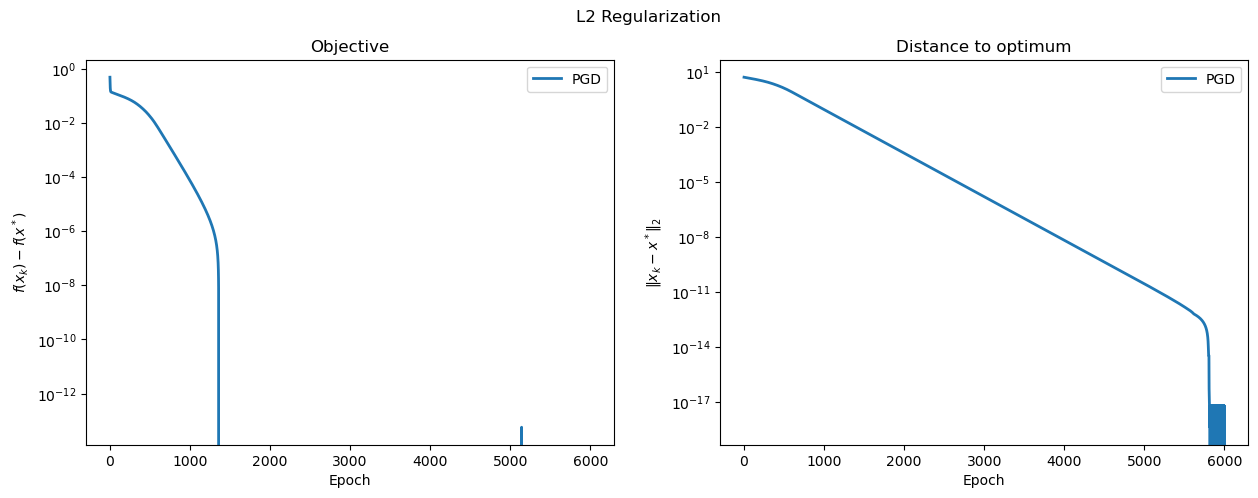

In [29]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0, noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 6000
lbda = 1
epsilon = 1.
""""
def compute_lipschitz_constant(X):
    n, p = X.shape
    # Augment X with a column of ones for the bias term
    X_augmented = np.hstack([X, np.ones((n, 1))])
    # Compute the Gram matrix
    gram_matrix = X_augmented.T @ X_augmented
    # Compute eigenvalues (sorted in ascending order)
    eigenvalues = np.linalg.eigvalsh(gram_matrix)
    # Maximum eigenvalue and Lipschitz constant
    L = (2 / n) * eigenvalues[-1]
    return L
"""

def compute_lipschitz_constant(X):
    n, p = X.shape
    # Maximum eigenvalue and Lipschitz constant
    L_b = 2
    L_w = (2 / n) * np.linalg.norm(X.T @ X,ord = 2)
    L = np.full(p+1,L_w)
    L[0] = L_b
    return L


def grad_huber_loss(params, X, y, epsilon):

    b = params[0]           # Intercept term
    w = params[1:]          # Weight vector

    residuals = y - (X @ w + b)

    # Compute Huber derivative
    huber_grad = np.zeros_like(residuals)
    mask = np.abs(residuals) < epsilon
    huber_grad[mask] = residuals[mask]
    huber_grad[~mask] = epsilon * np.sign(residuals[~mask])

    # Gradient with respect to b
    grad_b = -np.mean(huber_grad)

    # Gradient with respect to w
    grad_w = -X.T @ huber_grad / n_samples

    # Concatenate gradients for b and w
    grad = np.concatenate(([grad_b], grad_w))
    return grad


# step computation
step = 1/compute_lipschitz_constant(X)
step_w = step[1]
step_b = step[0]

#print(1/step_w)
#print(1/step_b)
x_min_l2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter = 10000, grad_args=(X, y, epsilon), prox_args=(step_w, lbda))
x_min_l1, _ = pgd(x_init, grad_huber_loss, prox_l1, step, n_iter = 10000, grad_args=(X, y, epsilon), prox_args=(step_w, lbda))

# TODO

# END TODO


monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers,args=("L2"))


When the PGD converges (and since the objective function is determined by PGD) it starts doing sign error because of the 10e-12 float definition.

Now for the $\ell_1$ regularization:

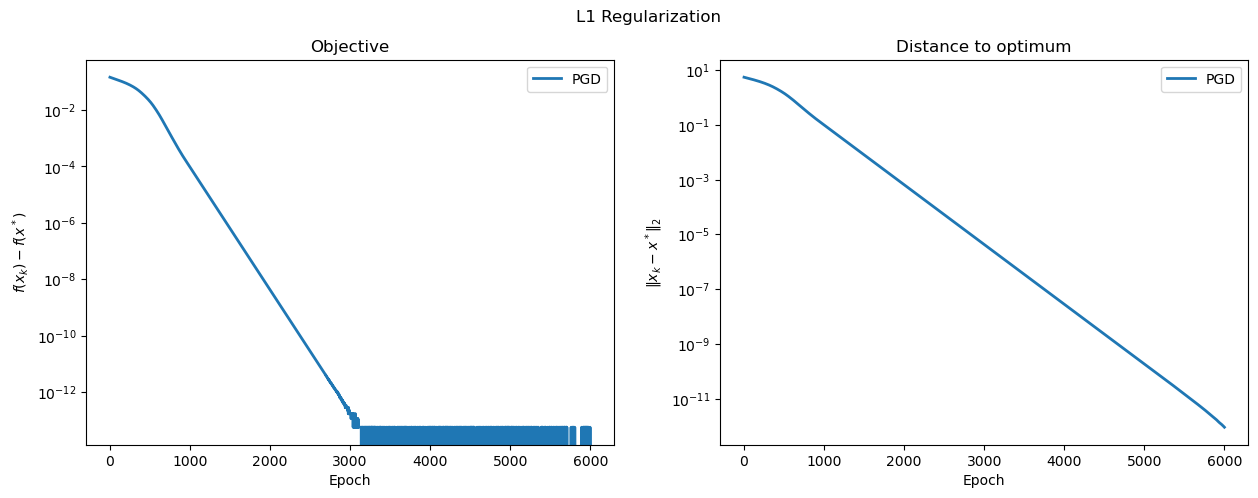

In [30]:
# Run PGD for L1
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers,args=("L1"))

<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [31]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=(), monitor_time = None):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    t_list = []
    t_start = time.time()
    for i in range(n_iter):
        ### TODO
        x_old = x.copy()
        x = prox(y - step * grad(y, *grad_args), *prox_args)
        t_old = t
        t = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x + (x - x_old) * (t_old - 1) / t

        ### END TODO
        if i % store_every == 0:
            t_list.append(time.time() - t_start)
            x_list.append(x.copy())

    if monitor_time :
        return x, x_list, t_list
    else :
        return x, x_list

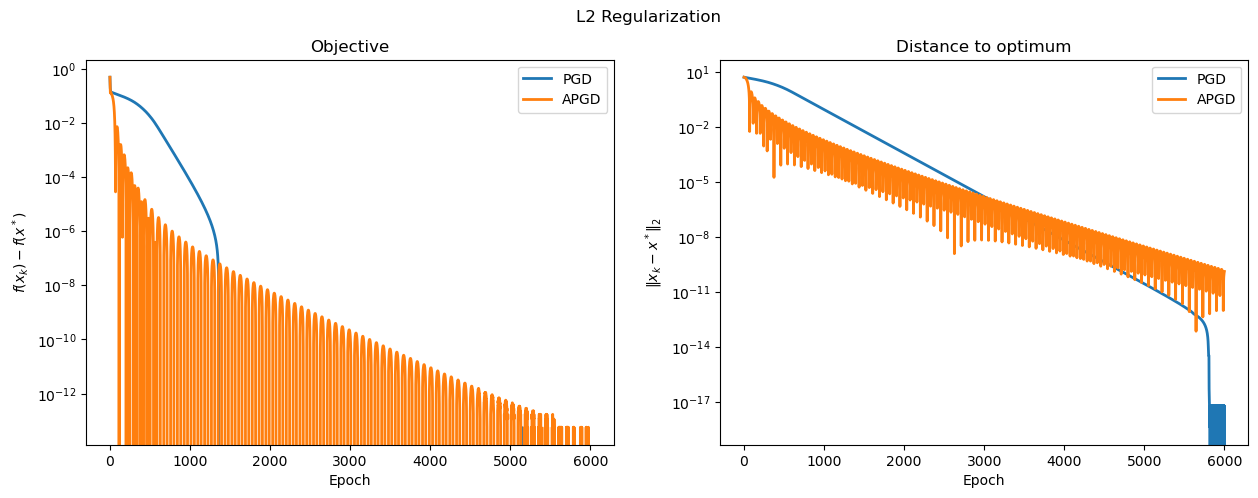

In [32]:
# TODO
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min_l2, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers,args=("L2"))

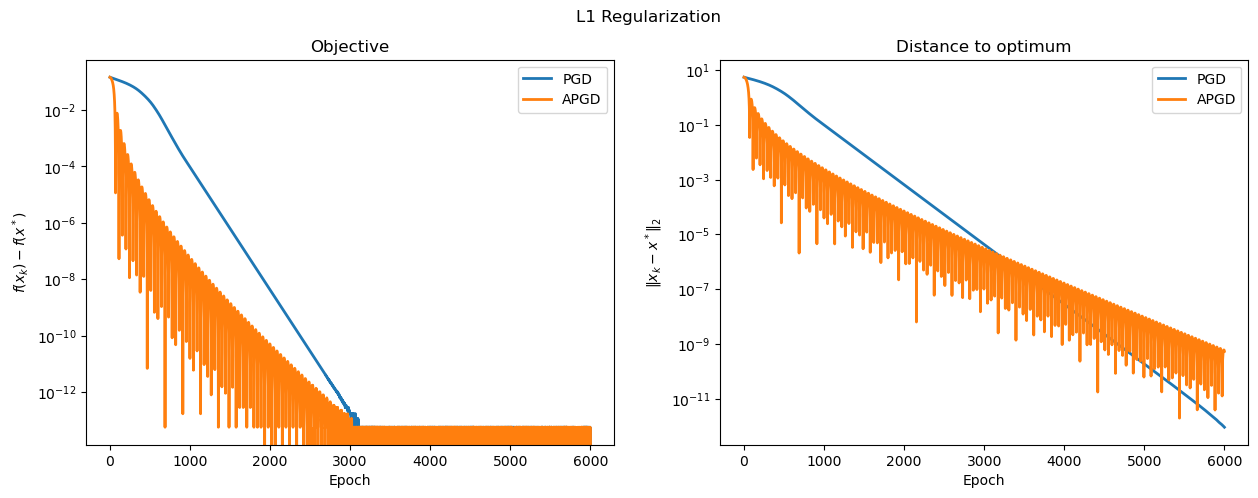

In [33]:
# TODO
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers,args=("L1"))

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
    </li>
    </ul>
</div>

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [34]:
# TODO
""" Proximal coordinate descent algorithm.	"""


def cd_prox_R2(x, reg=1.):
    return x/(1 + 2 * reg)


def cd_prox_R1(params, reg=1.):
    # TODO
    w = params
    w = np.sign(w) * np.maximum(np.abs(w) - reg, 0)
    # END TODO
    return w


def cd_prox_l2(params, step, lbda):
    return cd_prox_R2(params, reg=step * lbda)


def cd_prox_l1(params, step, lbda):
    return cd_prox_R1(params, reg=step * lbda)

"""
def gradient_j(X,residuals,j,mask,epsilon):
    return -1 * (X[mask,j].T @ residuals[mask] + X[~mask,j].T @ (epsilon * np.sign(residuals[~mask])) )
"""

def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=(), monitor_time = None):

    X, y, epsilon = grad_args[0], grad_args[1], grad_args[2]
    n_samples, n_features = X.shape

    # Initialize weights and bias
    x_list = []
    wb = x_init.copy()
    b = wb[0]
    w = wb[1:]
    residual = y - (X @ w) - b
    t_list= []
    t_start = time.time()
    for i in range(n_iter):
        #wb_old = wb.copy()

        # Update bias term b
        b_grad = -np.mean(
            np.where(np.abs(residual) <= epsilon, residual, epsilon * np.sign(residual))
        )
        b -= b_grad #/ n_samples
        residual += wb[0] - b
        wb[0] = b

        # Update each weight w_j
        j = i % n_features

        grad = -np.mean(
            X[:, j] * np.where(
                np.abs(residual) <= epsilon, residual, epsilon * np.sign(residual)
            )
        )

        new_w_j = prox(wb[1 + j] - step * grad, *prox_args)
        residual += X[:,j]* (wb[1 + j] - new_w_j)
        wb[1 + j] = new_w_j

        if i % store_every == 0:
            t_list.append(time.time() - t_start)
            x_list.append(wb.copy())
        """
        # Check for convergence
        if np.linalg.norm(wb - wb_old) < tol:
            print(f"Converged after {i + 1} iterations.")
            break
        """

    if monitor_time:
        return wb,x_list, t_list

    else:
        return wb,x_list

# END TODO

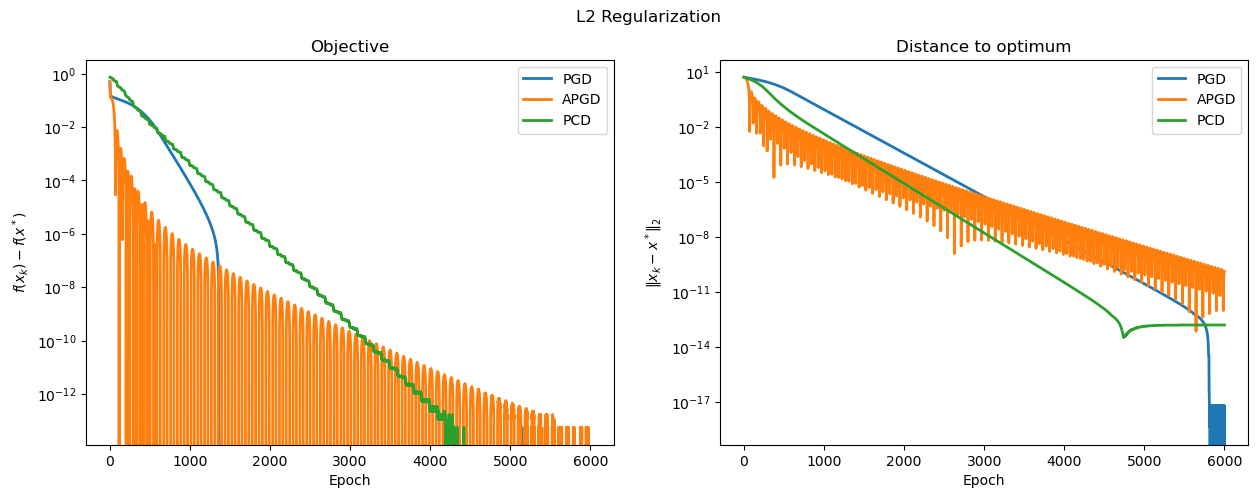

In [35]:
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_huber_loss, cd_prox_l2, step_b, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_b, lbda))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers,args=("L2"))

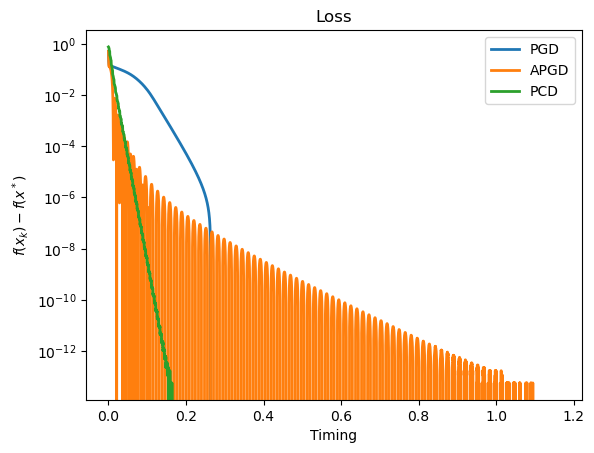

In [36]:
plot_time(monitors, solvers)

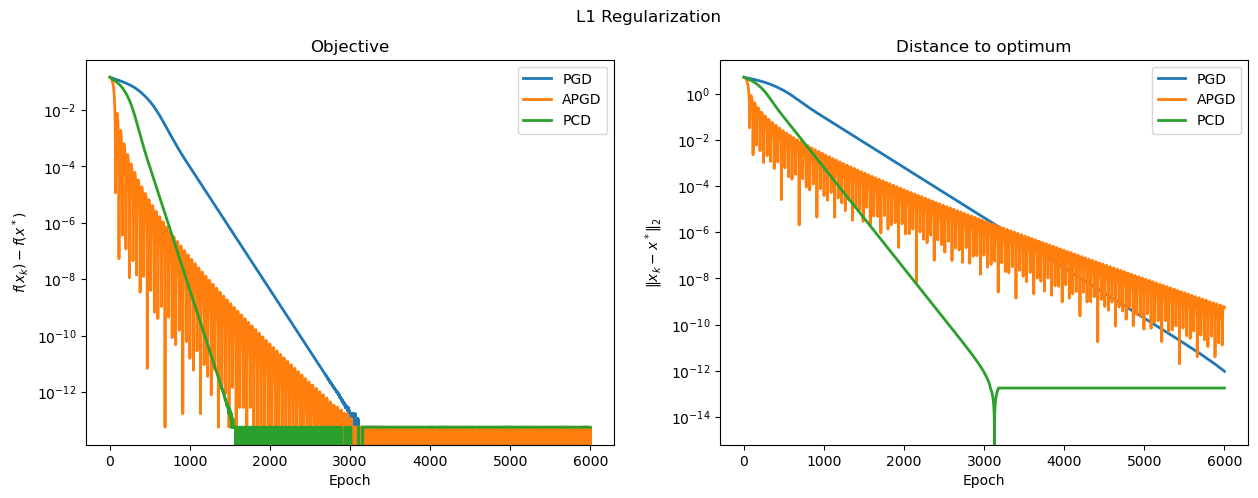

In [37]:
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_huber_loss, cd_prox_l1, step_b, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_b, lbda))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers,args=("L1"))

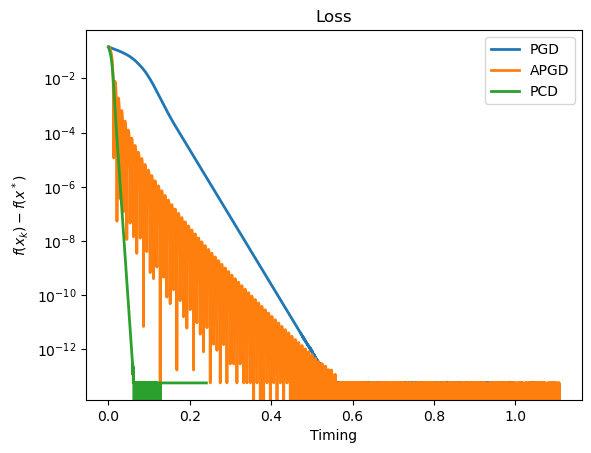

In [38]:
plot_time(monitors, solvers)

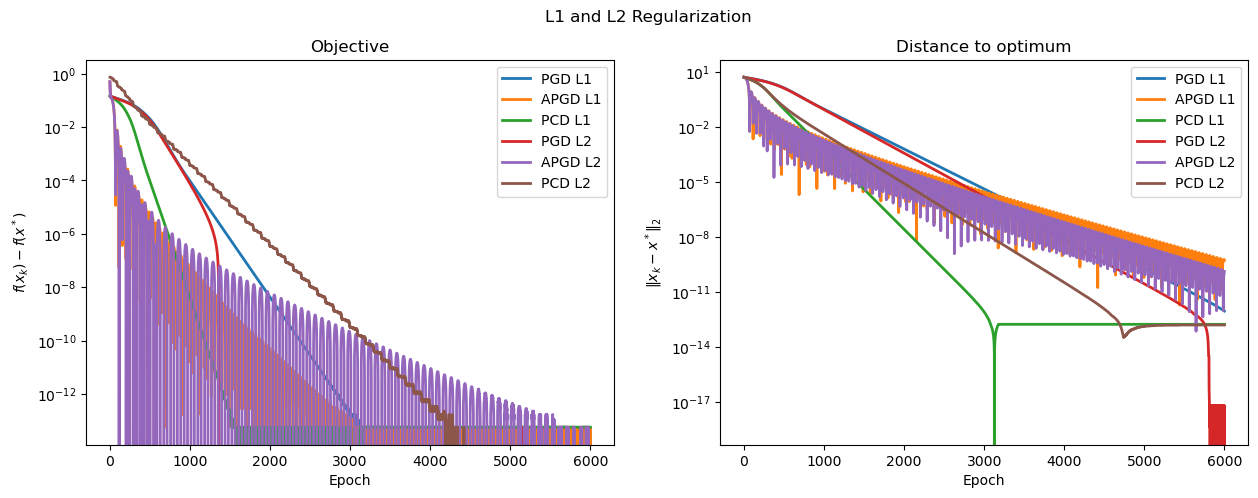

In [39]:
###All together for fun
monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1, monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD L1", "APGD L1", "PCD L1", "PGD L2", "APGD L2", "PCD L2"]
plot_epochs(monitors, solvers,args=("L1 and L2"))

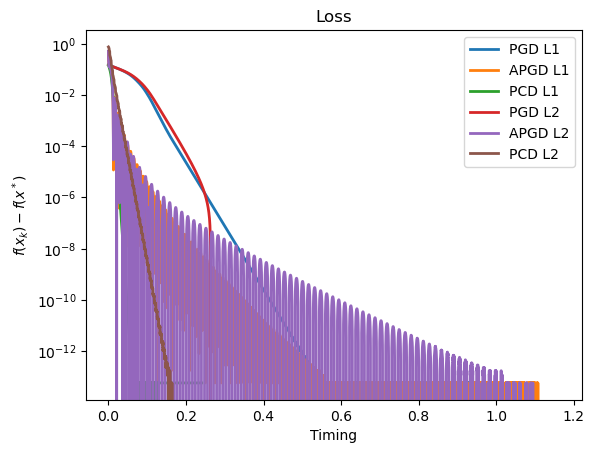

In [40]:
plot_time(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Compare the performance of the different solvers for different (simulated) problem sizes.
    </li>
    <li>
        What solver would you recommend for what problem and using what regularization?
    </li>
    </ul>
</div>

**Important**

This simulates different dataset sizes, it takes a long time to run so it is disabled by default. Please uncomment if you want to test it.

In [41]:
#simulate different dataset
"""
for k in range(500, 2000, 500):
      for i in range(500, 2000, 500):
        X, y = make_regression(n_samples=k, n_features=i, random_state=0, noise=4.0, bias=10.0)
        n_samples, n_features = X.shape

        # Set initial values of parameters to optimize
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y)
        n_iter = 6000
        lbda = 1
        epsilon = 1.
        step = 1/compute_lipschitz_constant(X)
        step_b = step[0]
        step_w = step[1:]
        x_min_l2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter = 7000, grad_args=(X, y, epsilon), prox_args=(step_w, lbda))
        x_min_l1 = x_min_l2
        monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, epsilon))
        monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))

        monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
        monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))

        monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min_l2, args=(X, y, lbda, epsilon))
        monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))

        monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
        monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))

        monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, epsilon))
        monitor_pcd_l2.run(x_init, grad_huber_loss, cd_prox_l2, step_b, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_b, lbda))

        monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
        monitor_pcd_l1.run(x_init, grad_huber_loss, cd_prox_l1, step_b, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(step_b, lbda))

        monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
        solvers = ["PGD", "APGD", "PCD"]
        plot_epochs(monitors, solvers)
        print(f'L2 regularization, n_samples = {k}, n_features = {i}')
        plt.show()

        monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
        solvers = ["PGD", "APGD", "PCD"]
        plot_epochs(monitors, solvers)
        print(f'L1 regularization, n_samples = {k}, n_features = {i}')
        plt.show()
    """

'\nfor k in range(500, 2000, 500):\n      for i in range(500, 2000, 500):\n        X, y = make_regression(n_samples=k, n_features=i, random_state=0, noise=4.0, bias=10.0)\n        n_samples, n_features = X.shape\n\n        # Set initial values of parameters to optimize\n        x_init = np.zeros(n_features + 1)\n        x_init[0] = np.mean(y)\n        n_iter = 6000\n        lbda = 1\n        epsilon = 1.\n        step = 1/compute_lipschitz_constant(X)\n        step_b = step[0]\n        step_w = step[1:]\n        x_min_l2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter = 7000, grad_args=(X, y, epsilon), prox_args=(step_w, lbda))\n        x_min_l1 = x_min_l2\n        monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, epsilon))\n        monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,\n                   grad_args=(X, y, epsilon), prox_args=(step_w, lbda))\n\n        monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, ep

For high dimensional problems the PCD with L1 regularization provides good convergence speed.

PCD works well with L1 regularization.

For L2 regularization, PGD and especially APGD provides the best convergence speed. Especially with high number of samples.

## Part 4: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [42]:
import pandas as pd

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [43]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

((8088, 2), (8088,))

In [44]:
print(max(y), min(y))

6.57612131900117 -0.105360515657826


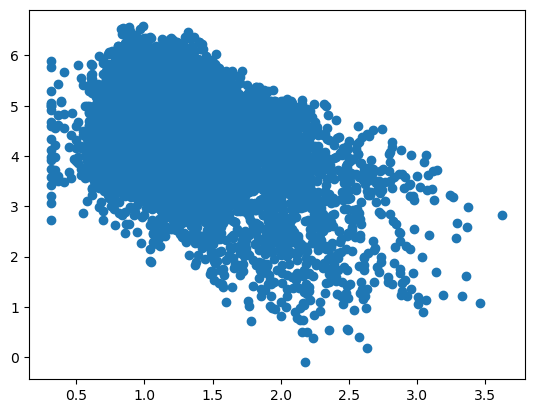

In [45]:
plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [46]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss

    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.

    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd']

    def fit(self, X, y):
        """Fit method

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        step = 1/compute_lipschitz_constant(X)

        step_b = step[0]
        step_w = step[1]

        if self.solver == 'pgd':
            if self.penalty == 'l1':
                self.prox = prox_l1
            else:
                self.prox = prox_l2

            x = np.zeros(n_features + 1)
            x[0] = np.mean(y)

            x, _, t_list = pgd(x, grad_huber_loss, self.prox, step, self.max_iter,
                    grad_args=(X, y, self.epsilon), prox_args=(step_w, self.lbda), monitor_time=True)
            self.t_list = t_list
            self.x_list = _
        elif self.solver == 'apgd':
            if self.penalty == 'l1':
                self.prox = prox_l1
            else:
                self.prox = prox_l2

            x = np.zeros(n_features + 1)
            x[0] = np.mean(y)

            x, _, t_list = apgd(x, grad_huber_loss, self.prox, step, self.max_iter,
                    grad_args=(X, y, self.epsilon), prox_args=(step_w, self.lbda), monitor_time=True)
            self.t_list = t_list
            self.x_list = _
        else:
            if self.penalty == 'l1':
                self.prox = cd_prox_l1
            else:
                self.prox = cd_prox_l2

            x = np.zeros(n_features + 1)
            x[0] = np.mean(y)

            x,_, t_list = pcd(x, grad_huber_loss, self.prox, step_b, self.max_iter,
                    grad_args=(X, y, self.epsilon), prox_args=(step_b, self.lbda), monitor_time=True)
            self.t_list = t_list
            self.x_list = _


        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_


    def score(self, X, y):
        """Score using negative mean absolute error

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.

        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))

<div class="alert alert-success">
    <b>QUESTION 14:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [47]:
def plot_heatmap(model, X, y, solver=None):
    # 1) Define mesh
    x1_min, x1_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
    x2_min, x2_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1

    resolution = 100
    x1_vals = np.linspace(x1_min, x1_max, resolution)
    x2_vals = np.linspace(x2_min, x2_max, resolution)
    xx1, xx2 = np.meshgrid(x1_vals, x2_vals)

    X_grid = np.column_stack((xx1.ravel(), xx2.ravel()))

    # 2) Predict on the grid
    y_pred_grid = model.predict(X_grid)
    y_pred_grid = y_pred_grid.reshape(xx1.shape)
    y_min = min(y)
    y_max = max(y)

    # 3) Plot as contourf
    plt.figure(figsize=(8,6))
    contour = plt.contourf(xx1, xx2, y_pred_grid, levels=30, cmap="viridis")
    plt.colorbar(contour, label="LNOx")

    # Overlay data points:
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', cmap="viridis", s=40)

    plt.xlabel("LNOxEm")
    plt.ylabel("sqrtWS")
    plt.title(f"{solver} heatmap of predicted values")
    plt.show()


In [48]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# TODO
#Lasso & Ridge
n_samples, n_features = X.shape
time_start = time.time()
lasso_estimator = Lasso(alpha = lbda, fit_intercept=True, max_iter=1000)
#we're taking the mean because cross_val_score return 5 cross validation run
lasso_score = np.mean(cross_val_score(lasso_estimator, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Lasso:\t-   MAE : {lasso_score}    \t-   Time : {time.time() - time_start}')

time_start = time.time()
ridge_estimator = Ridge(alpha = lbda, fit_intercept=True, max_iter=1000)
ridge_score = np.mean(cross_val_score(ridge_estimator, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Ridge:\t-   MAE : {ridge_score}    \t-   Time : {time.time() - time_start}')

epsilon = 10
## PGD
solver="pgd"
time_start = time.time()
clf_pgd_l2 = HuberRegressor(lbda=lbda, penalty='l2', max_iter=2000, solver=solver, epsilon=epsilon)
clf_pgd_l2_score = np.mean(cross_val_score(clf_pgd_l2, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Solver with L2: {solver}   \t-   MAE : {clf_pgd_l2_score}    \t-   Time : {time.time() - time_start}')

time_start = time.time()
clf_pgd_l1 = HuberRegressor(lbda=lbda, penalty='l1', max_iter=2000, solver=solver, epsilon=epsilon)
clf_pgd_l1_score = np.mean(cross_val_score(clf_pgd_l1, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Solver with L1: {solver}   \t-   MAE : {clf_pgd_l1_score}    \t-   Time : {time.time() - time_start}')


## APGD
solver="apgd"
time_start = time.time()
clf_apgd_l2 = HuberRegressor(lbda=lbda, penalty='l2', max_iter=2000, solver=solver, epsilon=epsilon)
clf_apgd_l2_score = np.mean(cross_val_score(clf_apgd_l2, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Solver with L2: {solver}   \t-   MAE : {clf_apgd_l2_score}    \t-   Time : {time.time() - time_start}')



time_start = time.time()
clf_apgd_l1 = HuberRegressor(lbda=lbda, penalty='l1', max_iter=2000, solver=solver, epsilon=epsilon)
clf_apgd_l1_score = np.mean(cross_val_score(clf_apgd_l1, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Solver with L1: {solver}   \t-   MAE : {clf_apgd_l1_score}    \t-   Time : {time.time() - time_start}')


##PCD
solver="pcd"
time_start = time.time()
clf_pcd_l2 = HuberRegressor(lbda=lbda, penalty='l2', max_iter=2000, solver=solver, epsilon=epsilon)
clf_pcd_l2_score = np.mean(cross_val_score(clf_pcd_l2, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Solver with L2: {solver}   \t-   MAE : {clf_pcd_l2_score}    \t-   Time : {time.time() - time_start}')


time_start = time.time()
clf_pcd_l1 = HuberRegressor(lbda=lbda, penalty='l1', max_iter=2000, solver=solver, epsilon=epsilon)
clf_pcd_l1_score = np.mean(cross_val_score(clf_pcd_l1, X, y, scoring='neg_mean_absolute_error', n_jobs=-1))
print(f'Solver with L1: {solver}   \t-   MAE : {clf_pcd_l1_score}    \t-   Time : {time.time() - time_start}')

Lasso:	-   MAE : -0.7235633302331101    	-   Time : 1.434927225112915
Ridge:	-   MAE : -0.4451855171168333    	-   Time : 0.7325899600982666
Solver with L2: pgd   	-   MAE : -0.6254475062397419    	-   Time : 1.8059334754943848
Solver with L1: pgd   	-   MAE : -0.7235633302331101    	-   Time : 1.6859376430511475
Solver with L2: apgd   	-   MAE : -0.6254475062399427    	-   Time : 1.0371363162994385
Solver with L1: apgd   	-   MAE : -0.7235633302331101    	-   Time : 1.0503692626953125
Solver with L2: pcd   	-   MAE : -0.6110526288795015    	-   Time : 1.333247184753418
Solver with L1: pcd   	-   MAE : -0.7235633302331103    	-   Time : 1.3515996932983398



With a high epsilon ($\varepsilon=10$) results of our HuberRegressor are comparable to the Ridge regression.
PCD method takes as much time as other methods.
L2 methods takes  more time to compute but have better overall results.
Let's their convergence speed.

We also plot a heatmap with ground truth data points to quickly check our results. We see that low wind and high LNOxEm implies high LNOx in ambient air which is correct.

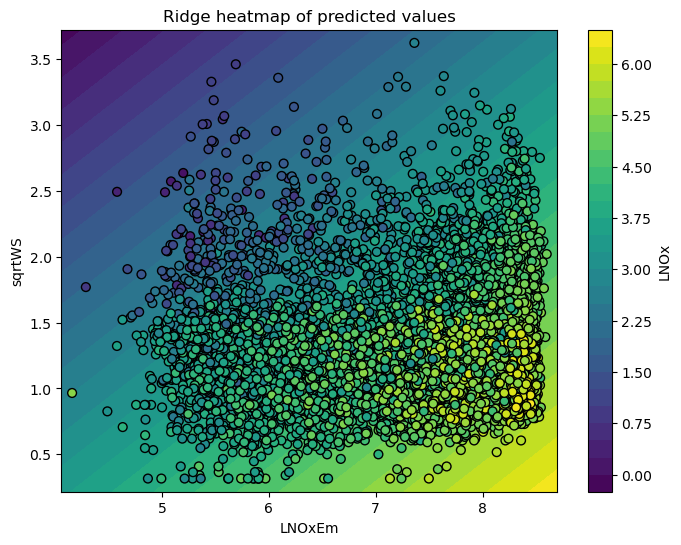

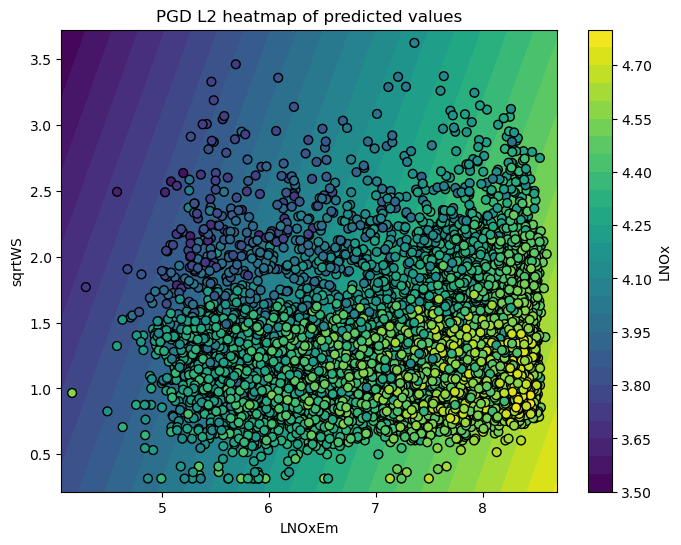

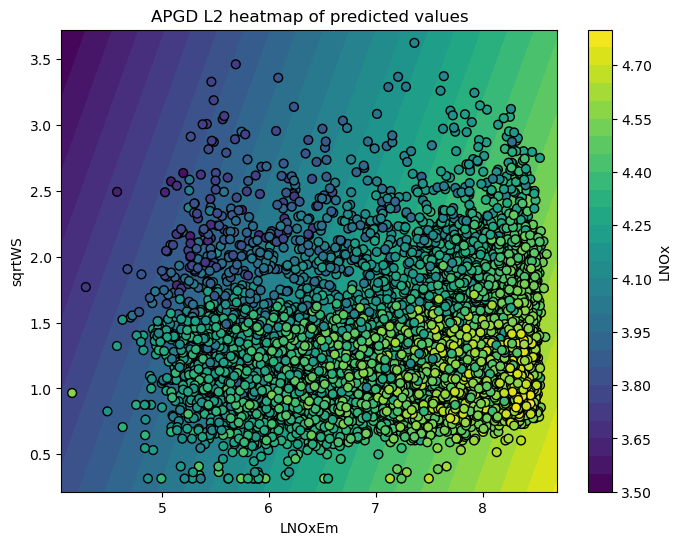

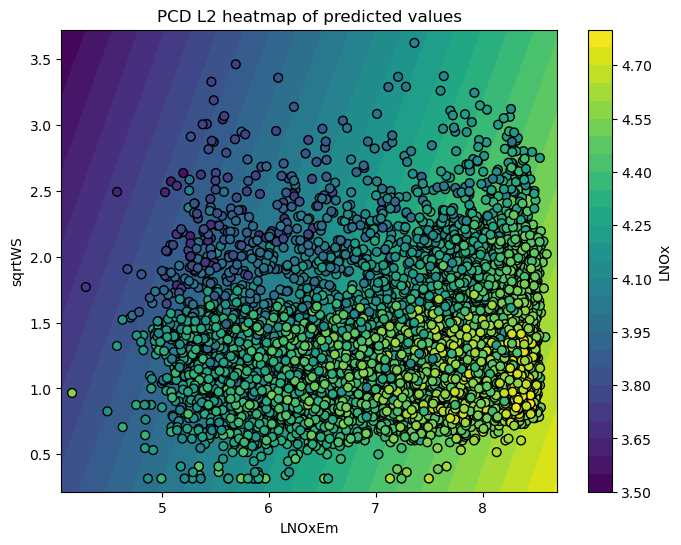

In [49]:
plot_heatmap(ridge_estimator.fit(X,y), X, y, "Ridge")
plot_heatmap(clf_pgd_l2.fit(X,y), X, y, "PGD L2")
plot_heatmap(clf_apgd_l2.fit(X,y), X, y, "APGD L2")
plot_heatmap(clf_pcd_l2.fit(X,y), X, y, "PCD L2")

Similar to previously, PCD seems to converge much faster than other algos, like before.

Text(0.5, 0, 'Time')

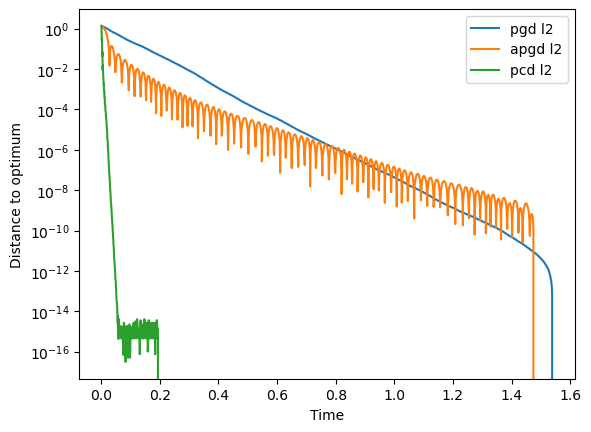

In [50]:
plt.figure()
legend = []
for k in [clf_pgd_l2, clf_apgd_l2, clf_pcd_l2]:
    x_list = k.x_list
    t_list = k.t_list
    x_list = [linalg.norm(k.params_ - j) for j in x_list]
    plt.plot(t_list, x_list)
    legend.append(f"{k.solver} {k.penalty}")

plt.yscale('log')
plt.ylabel('Distance to optimum')
plt.legend(legend)
plt.xlabel('Time')